# How to rediscover the Higgs boson yourself!
This notebook uses the new release of ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

ATLAS Open Data provides open access to proton-proton collision data at the LHC for educational purposes. ATLAS Open Data resources are ideal for high-school, undergraduate and postgraduate students.

Notebooks are web applications that allow you to create and share documents that can contain for example:
1. live code
2. visualisations
3. narrative text

The idea is that cuts increase the ratio of signal ($H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$) to background ($Z, t\bar{t}, ZZ \rightarrow \ell\ell\ell\ell$)

First, the amount of $Z$ and $t\bar{t}$ background is reduced, since these are quite different to the signal.

Then, the amount of $ZZ \rightarrow \ell\ell\ell\ell$ is reduced, whilst keeping as much $H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$ signal as possible.

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

This analysis loosely follows the [Measurement of inclusive and differential cross sections in the H->ZZ*->4l decay channel in pp collisions at $\sqrt{s} = 13~$TeV with the ATLAS detector](https://link.springer.com/article/10.1007/JHEP10(2017)132)

By the end of this notebook you will be able to:
1. rediscover the Higgs boson yourself!
2. know some general principles of a particle physics analysis

Feynman diagram pictures are borrowed from our friends at https://www.particlezoo.net

<a id='contents'></a>

Contents: 

[Running a Jupyter notebook](#running) <br />
[First time setup on your computer (no need on mybinder)](#setup_computer) <br />
[To setup everytime](#setup_everytime) <br />
[Lumi, fraction, file path](#fraction) <br />
[Samples](#samples) <br />
[Changing a cut](#changing_cut) <br />
[Applying a cut](#applying_cut) <br />
[Plotting](#plotting) <br />
[What can you do to explore this analysis?](#going_further) <br />

<a id='running'></a>

## Running a Jupyter notebook

To run the whole Jupyter notebook, in the top menu click Cell -> Run All.

To propagate a change you've made to a piece of code, click Cell -> Run All Below.

You can also run a single code cell, by clicking Cell -> Run Cells, or using the keyboard shortcut Shift+Enter.

<a id='setup_computer'></a>

## First time setup on your computer (no need on mybinder)
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If you open on mybinder, you don't need to run this cell.

In [1]:
import sys
import os.path
# update the pip package installer
!{sys.executable} -m pip install --upgrade --user pip
# install required packages
!{sys.executable} -m pip install --upgrade --user uproot awkward vector numpy matplotlib

[Back to contents](#contents)

<a id='setup_everytime'></a>

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in python
* awkward: lets us store data as awkward arrays, a format that generalizes numpy to nested data with possibly variable length lists
* vector: to allow vectorized 4-momentum calculations
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [2]:
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator # for minor ticks

#import infofile # local file containing cross-sections, sums of weights, dataset IDs

[Back to contents](#contents)

<a id='fraction'></a>

## Lumi, fraction, file path

General definitions of fraction of data used, where to access the input files

In [3]:
lumi = 36.6 # fb-1 # data size of the full release 

fraction = 1.0 # reduce this is if you want the code to run quicker
                                                                                                                                  
skim = "exactly4lepNew"
tuple_path = "/storage/eirikgr/OpenData/merged/"+skim+"/"

<a id='samples'></a>

## Samples

samples to process

In [4]:
samples = {

    'data': {
        'list' : ['data15_periodD','data15_periodF',
                  'data15_periodH','data16_periodA',
                  'data16_periodC','data16_periodE',
                  'data16_periodG','data16_periodK',
                  'data15_periodE','data15_periodG',
                  'data15_periodJ','data16_periodB',
                  'data16_periodD','data16_periodF',
                  'data16_PeriodI','data16_periodL'],
    },   
    'Background Z,t#bar{t},t#bar{t}+V,VVV' : { # Z+t+vvv
        'list' : ['410472.PhPy8EG_A14_ttbar_hdamp258p75_dil.exactly4lep',
                    '410155.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttW.exactly4lep',
                    '410218.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttee.exactly4lep',
                    '410219.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttmumu.exactly4lep',
                    '412043.aMcAtNloPythia8EvtGen_A14NNPDF31_SM4topsNLO.exactly4lep',
                    '364243.Sherpa_222_NNPDF30NNLO_WWZ_4l2v_EW6.exactly4lep',
                    '364242.Sherpa_222_NNPDF30NNLO_WWW_3l3v_EW6.exactly4lep',
                    '364246.Sherpa_222_NNPDF30NNLO_WZZ_3l3v_EW6.exactly4lep',
                    '364248.Sherpa_222_NNPDF30NNLO_ZZZ_4l2v_EW6.exactly4lep',
                    '700320.Sh_2211_Zee_maxHTpTV2_BFilter.exactly4lep',
                    '700321.Sh_2211_Zee_maxHTpTV2_CFilterBVeto.exactly4lep',
                    '700322.Sh_2211_Zee_maxHTpTV2_CVetoBVeto.exactly4lep',
                    '700323.Sh_2211_Zmumu_maxHTpTV2_BFilter.exactly4lep',
                    '700324.Sh_2211_Zmumu_maxHTpTV2_CFilterBVeto.exactly4lep',
                    '700325.Sh_2211_Zmumu_maxHTpTV2_CVetoBVeto.exactly4lep'],
        'color' : "#6b59d3" # purple
    },
    r'Background $ZZ^*$' : { # ZZ
        'list' : ['700600.Sh_2212_llll.exactly4lep',
                  '700601.Sh_2212_lllv.exactly4lep'],
        'color' : "#ff0000" # red
    },
    r'Signal ($m_H$ = 125 GeV)' : { # H -> ZZ -> llll
        'list' : ['345060.PowhegPythia8EvtGen_NNLOPS_nnlo_30_ggH125_ZZ4l.exactly4lep',
                    '346228.PowhegPy8EG_NNPDF30_AZNLOCTEQ6L1_VBFH125_ZZ4lep_notau.exactly4lep',
                    '346414.aMcAtNloPythia8EvtGen_tHjb125_4fl_ZZ4l.exactly4lep',
                    '346511.aMcAtNloPythia8EvtGen_tWH125_ZZ4l.exactly4lep',
                    '346310.PowhegPythia8EvtGen_NNPDF30_AZNLO_ZH125J_Zincl_H_incl_MINLO.exactly4lep',
                    '346311.PowhegPythia8EvtGen_NNPDF30_AZNLO_WpH125J_Wincl_H_incl_MINLO.exactly4lep',
                    '346312.PowhegPythia8EvtGen_NNPDF30_AZNLO_WmH125J_Wincl_H_incl_MINLO.exactly4lep',
                    '346340.PowhegPy8EG_A14NNPDF23_NNPDF30ME_ttH125_ZZ4l_allhad.exactly4lep',
                    '346341.PowhegPy8EG_A14NNPDF23_NNPDF30ME_ttH125_ZZ4l_semilep.exactly4lep',
                    '346342.PowhegPy8EG_A14NNPDF23_NNPDF30ME_ttH125_ZZ4l_dilep.exactly4lep',
                    '345066.PowhegPythia8EvtGen_NNPDF3_AZNLO_ggZH125_ZZ4lepZinc.exactly4lep'],
        'color' : "#00cdff" # light blue
    },
}

Units, as stored in the data files

In [5]:
MeV = 0.001
GeV = 1.0

[Back to contents](#contents)

Define function to get data from files.

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

In [6]:
def get_data_from_files():

    data = {} # define empty dictionary to hold awkward arrays
    for s in samples: # loop over samples
        #print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            prefix = ""
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"
            fileString = tuple_path+prefix+val+".root" # file name to open
            if not os.path.isfile(fileString):
                print("WARNING \t File %s does not exists. Skipping"%fileString)
                continue
            #print(fileString,val)
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append array returned from read_file to list of awkward arrays
        data[s] = ak.concatenate(frames) # dictionary entry is concatenated awkward arrays
    
    return data # return dictionary of awkward arrays

[Back to contents](#contents)

define function to calculate weight of MC event

In [7]:
def calc_weight(events):
    return (
        (lumi*1000*events.corrected_xsec
        * events.mcWeight
        * events.ScaleFactor_PILEUP
        * events.ScaleFactor_ELE
        * events.ScaleFactor_MUON)/(events.sum_of_weights)
        #* events.scaleFactor_LepTRIGGER
    )

define function to calculate 4-lepton invariant mass.

Note: `lep_(pt|eta|phi|E)` are variable length lists of lepton momentum components for each event, represented by awkward arrays.

In [8]:
def calc_mllll(lep_pt, lep_eta, lep_phi, lep_e):
    # construct awkward 4-vector array
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "e": lep_e})
    # calculate invariant mass of first 4 leptons
    # [:, i] selects the i-th lepton in each event
    # .M calculates the invariant mass
    return (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M

[Back to contents](#contents)

<a id='changing_cut'></a>

## Changing a cut

If you change a cut: Cell -> Run All Below

If you change a cut here, you also need to make sure the cut is applied in the "[Applying a cut](#applying_cut)" cell.

In [9]:
# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    return lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2] + lep_charge[:, 3] != 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2] + lep_type[:, 3]
    return (sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52)

[Back to contents](#contents)

<a id='applying_cut'></a>

## Applying a cut
If you add a cut: Cell -> Run All Below

In [10]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = [] # define empty list to hold all data for this sample
    
    # open the tree called mini using a context manager (will automatically close files/resources)
    with uproot.open(path + ":analysis") as tree:
        numevents = tree.num_entries # number of events
        #if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
        for data in tree.iterate(['lep_n','lep_pt','lep_eta','lep_phi','lep_z0','lep_d0',
                                  'lep_e','lep_charge','lep_type', 'lep_isTightID','lep_topoetcone20',
                                  'lep_ptvarcone30','lep_isLooseID','lep_isMediumID',
                                  # add more variables here if you make cuts on them 
                                  'mcWeight','ScaleFactor_PILEUP',
                                  'ScaleFactor_ELE','ScaleFactor_MUON',
                                  'sum_of_weights','corrected_xsec','xsec','num_events',
                                 'trigE','trigM'],
                                  #'ScaleFactor_LepTRIGGER'], # variables to calculate Monte Carlo weight
                                 library="ak", # choose output type as awkward array
                                 entry_stop=numevents*fraction): # process up to numevents*fraction

            nIn = len(data) # number of events in this batch
            
            data = data[data['lep_n'] == 4]
            
            # Produce flat variables for each lepton so that we can easilly cut on the later
            # ... or convert to hdf5 files
            for i in range(0,4):
                data[f'lep_pt{i+1}'] = data['lep_pt'][:,i]
                data[f'lep_tightID{i+1}'] = data['lep_isTightID'][:,i]
                data[f'lep_looseID{i+1}'] = data['lep_isLooseID'][:,i]
                data[f'lep_mediumID{i+1}'] = data['lep_isMediumID'][:,i]
                data[f'lep_topoetcone20{i+1}'] = data['lep_topoetcone20'][:,i]/data['lep_pt'][:,i]
                data[f'lep_ptvarcone30{i+1}'] = data['lep_ptvarcone30'][:,i]/data['lep_pt'][:,i]
                data[f'lep_type{i+1}'] = data['lep_type'][:,i]
                data[f'lep_z0sintheta{i+1}'] = data['lep_z0'][:,i]*np.sin(2*np.arctan(np.exp(-1.0*data["lep_eta"][:,i])))
                data[f'lep_d0{i+1}'] = data['lep_d0'][:,i]
        
            data = data[data['trigE'] | data['trigM']]
            
            # Isolation as explained in Section 4 (Event selection) in paper
            data = data[((data['lep_type1'] == 13) & (data['lep_topoetcone201']<0.3)) | \
                        ((data['lep_type1'] == 11) & (data['lep_topoetcone201']<0.2))]
            data = data[((data['lep_type2'] == 13) & (data['lep_topoetcone202']<0.3)) | \
                        ((data['lep_type2'] == 11) & (data['lep_topoetcone202']<0.2))]
            data = data[((data['lep_type3'] == 13) & (data['lep_topoetcone203']<0.3)) | \
                        ((data['lep_type3'] == 11) & (data['lep_topoetcone203']<0.2))]
            data = data[((data['lep_type4'] == 13) & (data['lep_topoetcone204']<0.3)) | \
                        ((data['lep_type4'] == 11) & (data['lep_topoetcone204']<0.2))]
            
            data = data[data['lep_ptvarcone301']<0.15]
            data = data[data['lep_ptvarcone302']<0.15]
            data = data[data['lep_ptvarcone303']<0.15]
            data = data[data['lep_ptvarcone304']<0.15]
            
            # Lepton identification as explained in Section 4 (Event selection) in paper
            data = data[((data['lep_type1'] == 13) ) | \
                        ((data['lep_type1'] == 11) & (abs(data['lep_looseID1'])==1))]
            data = data[((data['lep_type2'] == 13) ) | \
                        ((data['lep_type2'] == 11) & (abs(data['lep_looseID2'])==1))]
            data = data[((data['lep_type3'] == 13) ) | \
                        ((data['lep_type3'] == 11) & (abs(data['lep_looseID3'])==1))]
            data = data[((data['lep_type4'] == 13) ) | \
                        ((data['lep_type4'] == 11) & (abs(data['lep_looseID4'])==1))]
            
            # Cuts on transverse momentum
            data = data[data['lep_pt1'] > 20]
            data = data[data['lep_pt2'] > 15]
            data = data[data['lep_pt3'] > 10]
            
            if 'data' not in sample: # only do this for Monte Carlo simulation files
                data['totalWeight'] = calc_weight(data)
                
            # cut on lepton charge using the function cut_lep_charge defined above
            data = data[~cut_lep_charge(data.lep_charge)]

            # cut on lepton type using the function cut_lep_type defined above
            data = data[~cut_lep_type(data.lep_type)]

            # calculation of 4-lepton invariant mass using the function calc_mllll defined above
            data['mllll'] = calc_mllll(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_e)
            
            # multiple array columns can be printed at any stage like this
            #print(data[['lep_pt','lep_eta']])
            
            if not 'data' in sample:
                nOut = sum(data['totalWeight']) # sum of weights passing cuts in this batch 
            else:
                nOut = len(data)
            data_all.append(data) # append array from this batch
            elapsed = time.time() - start # time taken to process
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return ak.concatenate(data_all) # return array containing events passing all cuts

[Back to contents](#contents)

This is where the processing happens

In [11]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

	Processing: data15_periodD
		 nIn: 118,	 nOut: 	2	 in 0.4s
	Processing: data15_periodF
		 nIn: 713,	 nOut: 	15	 in 1.2s
	Processing: data15_periodH
		 nIn: 740,	 nOut: 	12	 in 0.5s
	Processing: data16_periodA
		 nIn: 1086,	 nOut: 	23	 in 2.2s
	Processing: data16_periodC
		 nIn: 5441,	 nOut: 	100	 in 8.2s
	Processing: data16_periodE
		 nIn: 2710,	 nOut: 	49	 in 1.7s
	Processing: data16_periodG
		 nIn: 6943,	 nOut: 	144	 in 5.6s
	Processing: data16_periodK
		 nIn: 3893,	 nOut: 	83	 in 2.8s
	Processing: data15_periodE
		 nIn: 1099,	 nOut: 	17	 in 1.5s
	Processing: data15_periodG
		 nIn: 1610,	 nOut: 	24	 in 2.8s
	Processing: data15_periodJ
		 nIn: 3237,	 nOut: 	48	 in 7.4s
	Processing: data16_periodB
		 nIn: 3338,	 nOut: 	55	 in 2.2s
	Processing: data16_periodD
		 nIn: 8233,	 nOut: 	177	 in 13.7s
	Processing: data16_periodF
		 nIn: 6031,	 nOut: 	125	 in 6.1s
	Processing: data16_PeriodI
		 nIn: 9585,	 nOut: 	221	 in 11.9s
	Processing: data16_periodL
		 nIn: 10378,	 nOut: 	268	 in 16.3s
	P

[Back to contents](#contents)

<a id='plotting'></a>

## Plotting
If you only want to make a change in plotting: Cell -> Run All Below

Define function to plot the data

In [12]:
def plot_data(data):
    
    var = 'mllll'

    xmin = 80 * GeV
    xmax = 170 * GeV
    step_size = 2.5 * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    print(bin_edges)
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(ak.to_numpy(data['data'][var]), 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)'][var]) # histogram the signal
    signal_weights = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)'].totalWeight) # get the weights of the signal events
    signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples.keys(): # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            print("Doing %s"%s)
            mc_x.append( ak.to_numpy(data[s][var]) ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( ak.to_numpy(data[s].totalWeight) ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, 
                                stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.2, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=16 ) 
    
    # Add text 'for education' on plot
    plt.text(0.2, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=10 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.2, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.2, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    
    plt.ylim(0, 40)
    
    return mc_weights

[Back to contents](#contents)

Call the function to plot the data

[ 80.   82.5  85.   87.5  90.   92.5  95.   97.5 100.  102.5 105.  107.5
 110.  112.5 115.  117.5 120.  122.5 125.  127.5 130.  132.5 135.  137.5
 140.  142.5 145.  147.5 150.  152.5 155.  157.5 160.  162.5 165.  167.5
 170. ]
Doing Background Z,t#bar{t},t#bar{t}+V,VVV
Doing Background $ZZ^*$


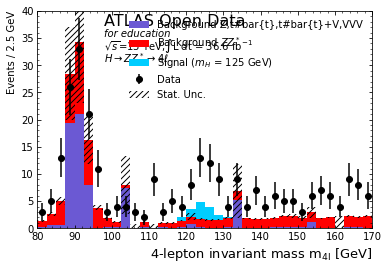

In [13]:
plt.rcParams["figure.figsize"] = (10,8)
mc_weights = plot_data(data)

# [Back to contents](#contents)

<a id='going_further'></a>

## What can you do to explore this analysis?

* Increase the fraction of data used in '[Lumi, fraction, file path](#fraction)'
* Check how many events are being thrown away by each cut in '[Applying a cut](#applying_cut)'
* Add more cuts from the [Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#se0040) in '[Changing a cut](#changing_cut)' and '[Applying a cut](#applying_cut)'
* Add a plot to show the ratio between Data and MC other than Higgs
* Add a plot to show the invariant mass distribution of the sub-leading lepton pair, like [Figure 1 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#fg0010)
* Get the estimated numbers of events, like [Table 3 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#tl0030)
* Add a plot of m12 against m34, like [Figure 3 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#fg0030)
* Your idea!

[Back to contents](#contents)